# R kernel

In [58]:
suppressMessages({
library(ggplot2)
library(dplyr)
library(tidyr)
library(ggpubr)
library(cowplot)
library(gridExtra)
library(rstatix)
library(reshape2)
library(ggnewscale)
library(RColorBrewer)
library(ComplexHeatmap)
library(SeuratDisk)
library(Seurat)
library(CellChat)
})

In [59]:
mytheme = function(){
theme_bw() +
theme(axis.text.x=element_text(size=6,color='black'),
    axis.text.y=element_text(size=6,color="black"),
    axis.title.y=element_text(size=6,color="black"),
    axis.title.x=element_text(size=6,color="black"),
    #axis.ticks.x=element_blank(),
    axis.ticks.length=unit(.02, "in"),
    axis.line = element_line(color = "black", linewidth = 0.25),
    axis.ticks = element_line(color = "black", linewidth = 0.25),
    strip.text.x = element_text(size = 6,margin = margin(0.1,0,0.1,0, "cm")),
    strip.text.y = element_text(size = 6,margin = margin(0,0.1,0,0.1, "cm")),
    strip.background=element_rect(linewidth=0.25),
    legend.text=element_text(size=6,color="black"),
    legend.title=element_text(size=6,color="black"),
    legend.key.width=unit(0.2,'cm'),
    legend.key.height=unit(0.2,'cm'),
    legend.box.margin=margin(0,0,0,2),
    legend.box.spacing = unit(0, "pt"),
    panel.spacing = unit(0.1, "cm"),
    plot.title = element_text(size=5),
    #panel.border = element_rect(size=0.25,color="black"),
    panel.grid = element_blank()
)
}

In [60]:
Fib_subtype_colors = c(
    "FB_COL11A1+" ="#2CA02CFF",
    "FB_COL18A1+" = "#ff9d3a",
    "FB_COL23A1+" = "#ff73b6",
    "FB_SFRP1+" = '#774898', 
    "FB_SFRP2+" =  '#00a8b5',
    "FB_SFRP4+" = "#f9e858",
    "FB_ASPN+" = "#d83034",
    "FB_Inflam" = "#c701ff",
    "FB_IFN" = "#008dff",
    "FB_Cycling" ='#BED754'
)
Endo_subtype_colors = c(
    "VEC_CCL14+"="#003a7d",
    "VEC_IFN"="#5e4c5f",
    "Perivascular"='#b7c9f2', 
    "LEC"='#e62a76'
)
subtype_color = c(Fib_subtype_colors, Endo_subtype_colors)

Fib_subtype_order = c("FB_COL11A1+","FB_COL18A1+","FB_COL23A1+",                       
                       "FB_SFRP1+","FB_SFRP2+","FB_SFRP4+",
                       "FB_ASPN+",
                       "FB_Inflam",
                       "FB_IFN",
                       "FB_Cycling")
Endo_subtype_order = c("VEC_CCL14+","VEC_IFN","Perivascular","LEC")
subtype_order = c(Fib_subtype_order,Endo_subtype_order)

## Fig.S12B

In [20]:
subtype_desity = read.csv("/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Tissue_line/Cell_density_subtype.csv",head=T)
subtype_desity = subset(subtype_desity, Location == 'Der' & (subtype == 'VEC_CCL14+' | subtype == 'FB_IFN'))
subtype_desity$group = factor(subtype_desity$group, levels = c('HC','DLE','SLE'))
subtype_desity$subtype = factor(subtype_desity$subtype, levels = c('VEC_CCL14+','FB_IFN'))

In [18]:
stat.test = subtype_desity %>%
  as.data.frame() %>%
  setNames(make.names(names(.), TRUE)) %>%
  group_by(subtype) %>%
  dunn_test(cell_density_mm2 ~ group)
stat.test = stat.test[stat.test$p.adj < 0.05,]
stat.test$p.format = sprintf("%.3f", stat.test$p.adj)
stat.test <- stat.test %>% mutate(y.position = c(260, 320))

png 
  2

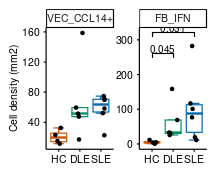

In [26]:
plot = ggplot(subtype_desity, aes(x=group,y=cell_density_mm2,color=group)) +
stat_boxplot( geom = "errorbar", width=0.5, linewidth=0.25) +
geom_boxplot(outlier.shape = NA,size=0.25) +  
geom_jitter(size=1,width=0.2,color='black',alpha=1,shape=19, stroke=NA) +
facet_wrap(.~subtype, scale='free_y') +
stat_pvalue_manual(stat.test,label = "p.format",label.size=2, bracket.size=0.25, tip.length = 0.03, hide.ns=TRUE) +
labs(x="",y='Cell density (mm2)') +
scale_color_manual(values=group_color) +
mytheme() + 
theme(legend.position = 'none',    
    strip.text.x = element_text(size = 6,margin = margin(0.07,0,0.07,0, "cm")), 
    strip.background=element_rect(linewidth=0.25, color='black', fill="white"),
    panel.border = element_blank()
)

options(repr.plot.width =1.8,repr.plot.height =1.6)
plot
pdf("../../figures/Cellbin_VEC_CCL14_FB_IFN_desity.pdf",w=1.8,h=1.6)
plot
dev.off()

## Fig.S12C

In [26]:
ring_density = read.csv("/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Celltype_analysis/Immu_cell/TLS/stromal_density_TLS_ring.csv",head=T)

In [27]:
ring_density$subtype = factor(ring_density$subtype, levels = subtype_order)
ring_density$ring = ring_density$ring*0.5

In [28]:
Other_subtype = subset(ring_density, subtype != 'VEC_CCL14+')

In [119]:
compares1 = list(c("20","40"),c("20","60"),c("20","80"),c("20","100"))#,c("40","60"),c("40","80"),c("40","100"),c("60","80"),c("60","100"),c("80","100"))
compares2 = list(c("-20","-40"),c("-20","-60"),c("-20","-80"),c("-20","-100"))#,c("-40","-60"),c("-40","-80"),c("-40","-100"),c("-60","-80"),c("-60","-100"),c("-80","-100"))
compares = c(compares1, compares2)

In [120]:
stat.test <- Other_subtype %>%
  group_by(subtype) %>% 
  wilcox_test(subtype_density ~ ring, comparisons = compares) %>%
  adjust_pvalue(method = "none") %>%
  add_significance() %>%
  add_xy_position(x = "ring", dodge = 0.5)

In [130]:
stat.test = stat.test[stat.test$p.adj < 0.05,]
stat.test <- stat.test %>% mutate(y.position = c(100,100,180,150,100,180,100,250,330,410,450,100,180,100))

png 
  2

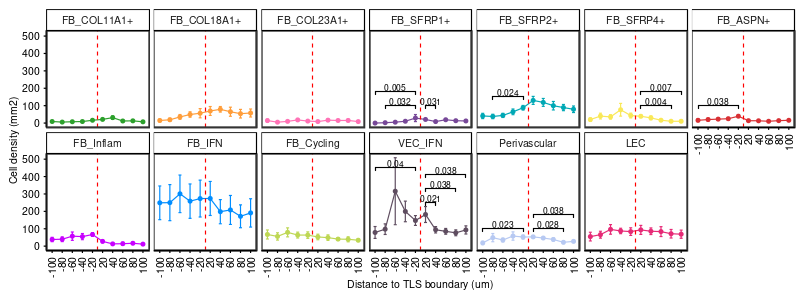

In [134]:
plot = ggline(Other_subtype, x="ring", y="subtype_density", add=c("mean_se"),  error.plot = "errorbar",
            add.params = list(size = 1, width = 0.3), color='subtype', facet.by='subtype', shape=20, stroke=NA, size=0.25, #palette = celltype_color,
            point.size = 0.5, nrow=2) +  
    geom_vline(xintercept=5.5, lwd=0.25, lty=2, color='red') + 
    stat_pvalue_manual(stat.test, label = "p", label.size=1.7, hide.ns=T, bracket.size=0.25, tip.length = 0.01) +
    labs(x='Distance to TLS boundary (um)', y='Cell density (mm2)') +
    scale_color_manual(values=subtype_color) +
    mytheme() +
    theme(axis.text.x=element_text(size=6,color="black",angle=90,hjust=1,vjust=0.5),
    plot.title=element_text(size=6,color="black"),
    strip.background=element_rect(size=0.25, color='black', fill="white"),
    legend.position = "none"
)
options(repr.plot.width =6.7,repr.plot.height =2.5)
plot
pdf("../../figures/TLS_other_subtype_ring_density.pdf",w=6.7,h=2.5)
plot
dev.off()

## Fig.S12D

In [61]:
subtype_den = read.csv("/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Tissue_line/Cell_density_subtype_Der_dist.csv", head=T, row.names=1)
celltype_den = read.csv("/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Tissue_line/Cell_density_celltype_Der_dist.csv", head=T, row.names=1)

In [62]:
merge = merge(subtype_den,celltype_den, by = 'sample')
Celltype = c('T cells', 'NK cells', 'B cells', 'Plasma cells', 'Mast cells')
FB_other = subset(merge, subtype == 'FB_IFN' & celltype %in% Celltype)
FB_other$celltype = factor(FB_other$celltype, levels=Celltype)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

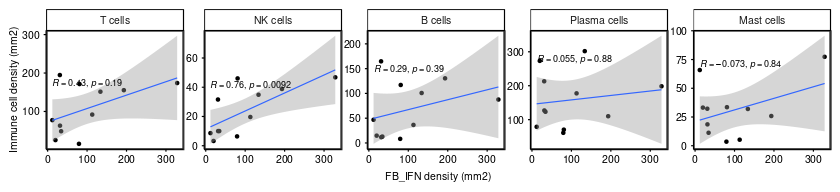

In [66]:
plot = ggplot(FB_other, aes(x=cell_density_mm2.x, y=cell_density_mm2.y)) + 
    geom_point(shape=19, stroke=NA, size=1) +
    geom_smooth(method=lm, lwd=0.25) +
    stat_cor(size=1.8,method = "spearman") +
    facet_wrap(.~celltype, ncol=5, scale='free') + 
    labs(y = "Immune cell density (mm2)", x = "FB_IFN density (mm2)") + 
    mytheme() + 
    theme(strip.background=element_rect(size=0.25, color='black', fill="white"))

options(repr.plot.width= 7,repr.plot.height = 1.6)
plot

pdf("../../figures/FB_IFN_Other_Immune_density_correlation.pdf",w=6, h=1.5)
plot
dev.off()

## Fig.S12E

Only reorder cell groups but do not rename cell groups!

Reorder cell groups! 



The cell group order before reordering is  B cells FB_ASPN+ FB_COL11A1+ FB_COL18A1+ FB_COL23A1+ FB_Cycling FB_IFN FB_Inflam FB_SFRP1+ FB_SFRP2+ FB_SFRP4+ Macrophage/DC Mast cells NK cells Plasma cells T cells 
The cell group order after reordering is  FB_COL11A1+ FB_COL18A1+ FB_COL23A1+ FB_SFRP1+ FB_SFRP2+ FB_SFRP4+ FB_ASPN+ FB_Inflam FB_IFN FB_Cycling T cells NK cells B cells Plasma cells Macrophage/DC Mast cells 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



Only reorder cell groups but do not rename cell groups!

Reorder cell groups! 



The cell group order before reordering is  B cells FB_ASPN+ FB_COL11A1+ FB_COL18A1+ FB_COL23A1+ FB_Cycling FB_IFN FB_Inflam FB_SFRP1+ FB_SFRP2+ FB_SFRP4+ Macrophage/DC Mast cells NK cells Plasma cells T cells 
The cell group order after reordering is  FB_COL11A1+ FB_COL18A1+ FB_COL23A1+ FB_SFRP1+ FB_SFRP2+ FB_SFRP4+ FB_ASPN+ FB_Inflam FB_IFN FB_Cycling T cells NK cells B cells Plasma cells Macrophage/DC Mast cells 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



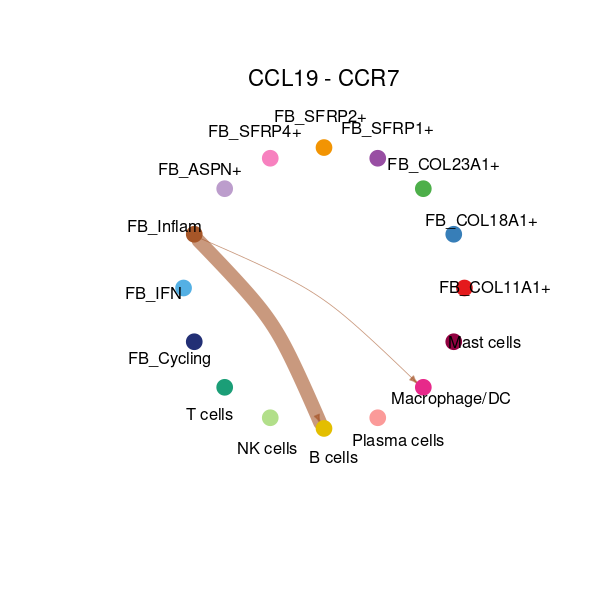

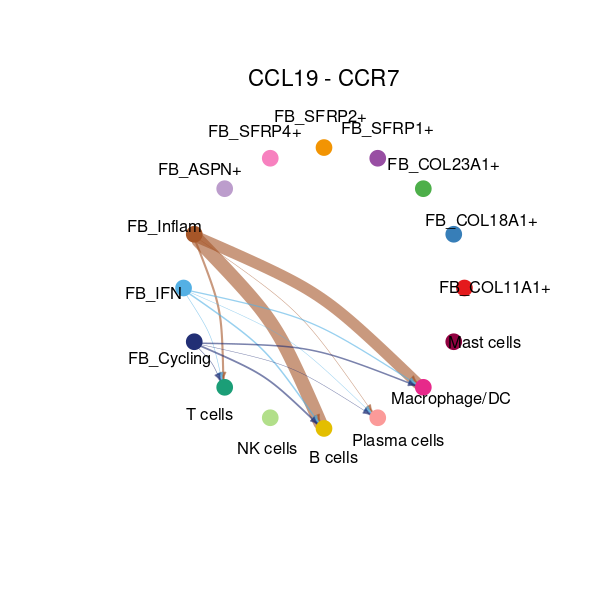

In [51]:
Immune_celltypes = c('T cells','NK cells','B cells','Plasma cells','Macrophage/DC','Mast cells')
cell_order = c(Fib_subtype_order, Immune_celltypes)

samples = c("HC","LE")
merge_data = data.frame()
plots <- list()
for (i in 1:length(samples))
{
cellchat <- readRDS(paste0("/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Celltype_analysis/Fib_Endo/Cellchat/Fib_subtype_Immune_celltype_",samples[i],"_0.2.rds"))

re_order <- cell_order[cell_order %in% rownames(cellchat@net$weight)]
cellchat <- updateClusterLabels(cellchat, new.order=re_order)
    
options(repr.plot.width= 5,repr.plot.height = 5)
netVisual_individual(cellchat, signaling =  c("CCL"), pairLR.use = "CCL19_CCR7", layout = "circle", arrow.size=0.5, vertex.label.cex = 0.8, 
                     sources.use=Fib_celltype_order, targets.use=Immune_celltypes)
}

## Fig.S12G

In [45]:
SC_rds = readRDS("/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/SC_data/SC_anno/scRNA_harmony_subtype_20240823.rds")

In [46]:
Fib_celltype_need = c('Fibroblasts','T cells','NK cells','B cells','Plasma cells','Macrophage/DC','Mast cells')
Fib_Immu_rds = subset(SC_rds, celltype %in% Fib_celltype_need)
Fib_Immu_rds$celltype = as.character(Fib_Immu_rds$celltype)
Fib_Immu_rds$subtype = as.character(Fib_Immu_rds$subtype)
Fib_Immu_rds$type = ifelse(Fib_Immu_rds$celltype == "Fibroblasts", Fib_Immu_rds$subtype, Fib_Immu_rds$celltype)

In [48]:
Fib_Immu_rds$disease = ifelse(Fib_Immu_rds$groups == "DLE", "LE", 
                                   ifelse(Fib_Immu_rds$groups == "SLE", "LE", "HC"))

In [49]:
gene <- c('CXCL12','CXCR4','CCL19','CCR7')
plot_data_merge = data.frame()

samples <- c("HC","LE") 
for(i in (1:length(samples))){
    sub <- subset(Fib_Immu_rds,disease==samples[i])
    plot_data = DotPlot(sub, features=gene, group.by='type',dot.scale = 2)$data
    plot_data$group = samples[i]
    plot_data_merge = rbind(plot_data_merge, plot_data)
}

In [52]:
Immune_celltypes = c('T cells','NK cells','B cells','Plasma cells','Macrophage/DC','Mast cells')
cell_order = c(Fib_subtype_order, Immune_celltypes)
plot_data_merge$id = factor(plot_data_merge$id, levels =rev(cell_order))

png 
  2

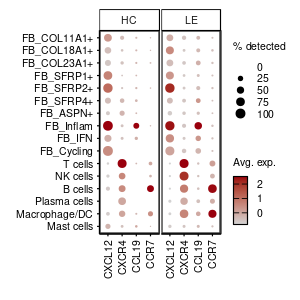

In [54]:
p <- ggplot(plot_data_merge,aes(x=features.plot,y = id,size = pct.exp, color = avg.exp.scaled))+
    geom_point(shape=19, stroke=NA)+
    scale_size("% detected", range = c(0,2.5)) +
    scale_color_gradient(low = "lightgrey",high = "#99000D",guide = guide_colorbar(ticks.colour = "black", 
                        theme = theme(legend.frame = element_rect(colour = "black", linewidth=0.25))),name = "Avg. exp.")+
    facet_grid(~group, scales="free_x",space = "free") + 
    labs(x="",y="") +
    mytheme() +
    theme(axis.text.x=element_text(size=6, angle=90, hjust=1,vjust=0.5),
        strip.background=element_rect(linewidth=0.25, color='black', fill="white"),
        legend.key.width=unit(0.3,'cm'),
        legend.key.height=unit(0.2,'cm'),
        panel.spacing = unit(0.05, "cm")
)
options(repr.plot.width = 2.5,repr.plot.height =2.5)
p
pdf('../../figures/Fib_Immu_CXCL_CCL_expr_dotplot.pdf',w=2.5,h=2.5)
p
dev.off()

# Python kernel

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
from shapely.geometry import GeometryCollection, Polygon
import matplotlib.backends.backend_pdf as pdf_backend
import warnings
warnings.filterwarnings('ignore')
import importlib

import utils_20250718
importlib.reload(utils_20250718)
from utils_20250718 import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
ST_adata = sc.read_h5ad('/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Cellbin_h5ad_raw/All_samples_Cellbin_filter_gene200_add_anno_dist.h5ad')
sc.pp.normalize_total(ST_adata, target_sum=10000)
sc.pp.log1p(ST_adata)

## Fig.S12A

In [5]:
Fib_subtype_order = ["FB_COL11A1+","FB_COL18A1+","FB_COL23A1+",                       
                       "FB_SFRP1+","FB_SFRP2+","FB_SFRP4+",
                       "FB_ASPN+",
                       "FB_Inflam",
                       "FB_IFN",
                       "FB_Cycling"]

In [6]:
Fib_adata = sc.read("../Fib_adata.h5ad")
sc.pp.normalize_total(Fib_adata, target_sum=10000)
sc.pp.log1p(Fib_adata)
Fib_adata.obs['subtype'] = pd.Categorical(Fib_adata.obs['subtype'], categories=Fib_subtype_order)

In [8]:
Fib_marker_gene = [
"COL11A1","POSTN","DPEP1",
"COL18A1","APCDD1","WIF1",
"COL23A1","TBX3","THBS1",
"SFRP1","IGFBP2","SPON2",
"SFRP2","CCN5","SLPI",
"SFRP4","CLDN1","TAGLN",
"ASPN","TNN","COCH",
"CXCL12","CCL19","CXCL2",
"IFIT1","ISG15","ISG20",
"MKI67","TOP2A","UBE2C"
]

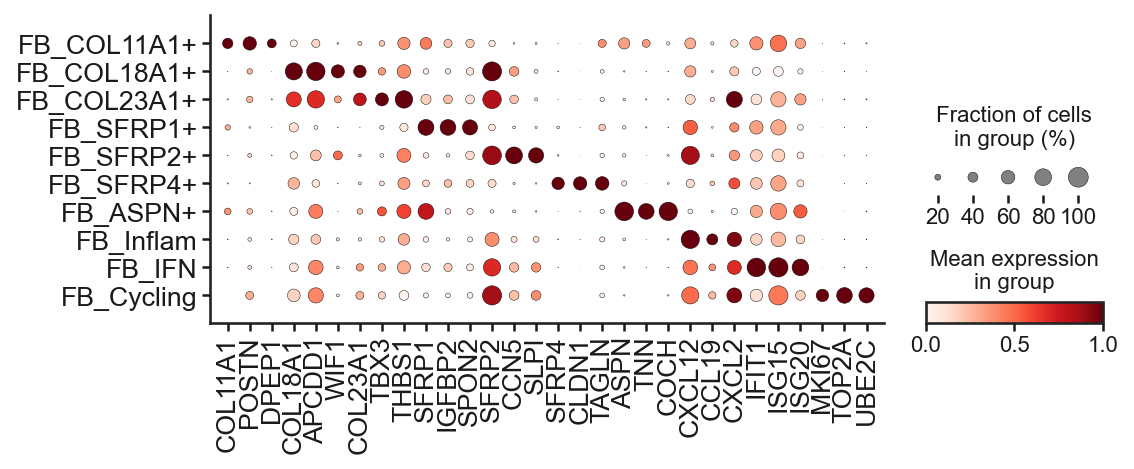

In [20]:
axes_dict = sc.pl.dotplot(Fib_adata, Fib_marker_gene, groupby='subtype', figsize=(7.2,2.5), standard_scale='var',show=False, return_fig=True, use_raw=False)
axes_dict.style(largest_dot=80, cmap='Reds')
main_ax = axes_dict.get_axes()['mainplot_ax']
main_ax.tick_params(axis='both', labelsize=12)
main_ax.figure.savefig(f'../../figures/Fib_subtype_dotplot.pdf')

In [13]:
Endo_subtype_order = ["VEC_CCL14+","VEC_IFN","Perivascular","LEC"]

In [14]:
Endo_adata = sc.read("../Endo_adata.h5ad")
sc.pp.normalize_total(Endo_adata, target_sum=10000)
sc.pp.log1p(Endo_adata)
Endo_adata.obs['subtype'] = pd.Categorical(Endo_adata.obs['subtype'], categories=Endo_subtype_order)

In [15]:
Endo_marker_gene = [
    "CCL14","MYC","CCN2",
    "IFI44L","IFI6","ISG15",
    'TAGLN',"MYL9","ACTA2",
    "CCL21","LYVE1","PROX1"
]

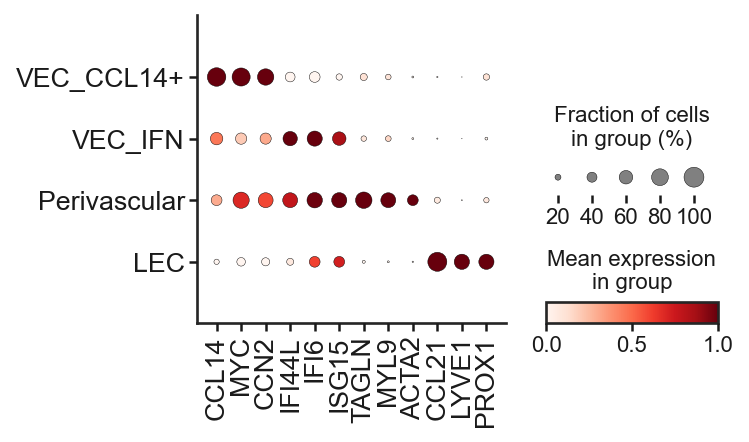

In [22]:
axes_dict = sc.pl.dotplot(Endo_adata, Endo_marker_gene, groupby='subtype', figsize=(4.2,2.5), standard_scale='var',show=False, return_fig=True, use_raw=False)
axes_dict.style(largest_dot=80, cmap='Reds')
main_ax = axes_dict.get_axes()['mainplot_ax']
main_ax.tick_params(axis='both', labelsize=12)
main_ax.figure.savefig(f'../../figures/Endo_subtype_dotplot.pdf')

## Fig.S12F

In [5]:
LRs =[['CCL19','CCR7']]

[12:02:46] ❕  ssat is not registered, register now                                           ]8;id=943135;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=561289;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

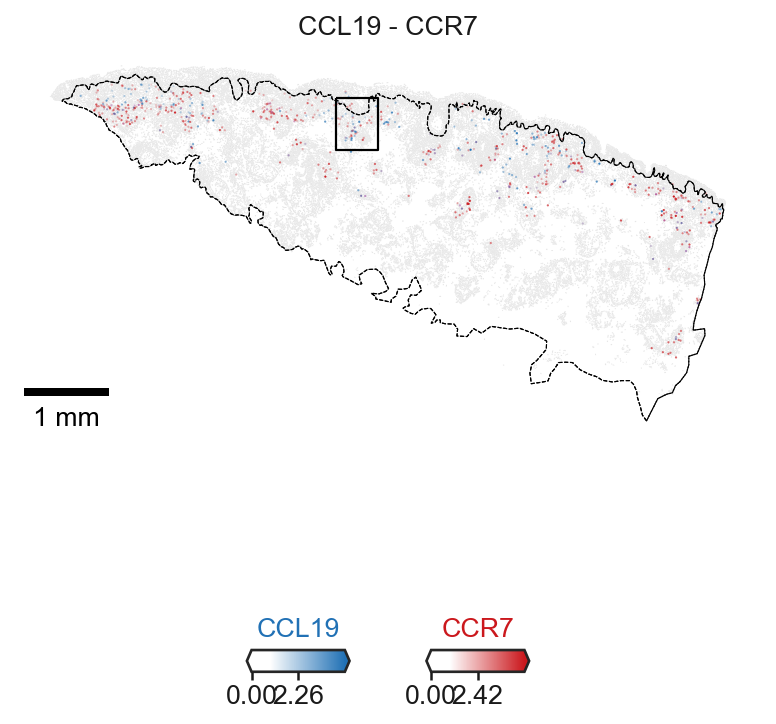

In [7]:
polygons = [
            [Polygon([[16500,17600], [17500,17600],[17500,16400], [16500,16400]])]
           ]

Der_shp = gpd.read_file(f"/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Tissue_line/SHP_file/SLE2_Der_tussue_contour.shp")
SLE2_adata = ST_adata[ST_adata.obs['sample'] == 'SLE2']  

for i, gene in enumerate(LRs):
    ligand_gene = LRs[i][0]
    receptor_gene = LRs[i][1]
    source_ligand = (SLE2_adata.obs.subtype.isin(['FB_IFN'])) & (fetch_data(SLE2_adata, ligand_gene).sum(axis=1) > 0)
    target_receptor = (SLE2_adata.obs.celltype.isin(['Macrophage/DC','T cells',"B cells"])) & (fetch_data(SLE2_adata, receptor_gene).sum(axis=1) > 0)
    ax = plot_spatial(SLE2_adata[source_ligand | target_receptor], 
                      [ligand_gene,receptor_gene], 
                      reduction='spatial', dot_size=1, show_img=False, max_color_quantile=.95, figsize=[6,6], raster=False, 
                      style='fast', reorder_cmap=[2,1])
    
    dimplot(SLE2_adata, background=True, reduction='contour',  ax=ax, raster=False)
    Der_shp.plot(ax=ax, edgecolor='black',facecolor='none', linewidth=0.5, linestyle='--')
    draw_scalebar(ax=ax, location='lower left', color='black')
    ax.set_title(f"{ligand_gene} - {receptor_gene}")
    gpd.GeoSeries(polygons[i]).plot(ax=ax, edgecolor='black',facecolor='none', linewidth=1)

[14:00:33] 📃  Filtering contour within bounding box [16500, 16400, 17500, 17600]            ]8;id=6381;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=759807;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=135010;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=620744;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

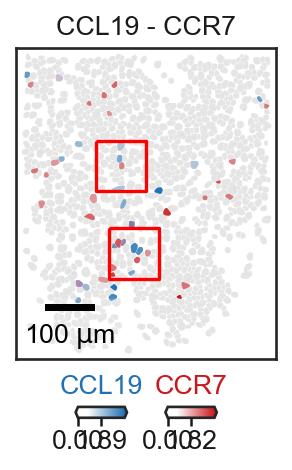

In [25]:
polygons = [
            [Polygon([[16800,17250], [17000,17250],[17000,17050], [16800,17050]]), Polygon([[16850,16900], [17050,16900],[17050,16700], [16850,16700]])]
           ]

TLS_shp = gpd.read_file(f"/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Celltype_analysis/Immu_cell/TLS/Cell_contour_shp/SLE2_cell_contour.shp")
SLE2_adata = ST_adata[ST_adata.obs['sample'] == 'SLE2']  

zone = [[16500,16400,17500,17600]]

for i, gene in enumerate(LRs):
    ligand_gene = LRs[i][0]
    receptor_gene = LRs[i][1]
    zone_adata = within(SLE2_adata, zone[i], reduction ='contour', inplace=True)
    source_ligand = (zone_adata.obs.subtype.isin(['FB_IFN'])) & (fetch_data(zone_adata, ligand_gene).sum(axis=1) > 0)
    target_receptor = (zone_adata.obs.celltype.isin(['Macrophage/DC','T cells',"B cells"])) & (fetch_data(zone_adata, receptor_gene).sum(axis=1) > 0)      
    
    ax = plot_spatial(zone_adata[source_ligand | target_receptor], 
                      [ligand_gene,receptor_gene], 
                      reduction='contour', show_img=False, max_color_quantile=.95, figsize=[3,3], raster=False, 
                      style='fast', reorder_cmap=[2,1])
    
    dimplot(zone_adata, reduction='contour', ax=ax, raster=False)
    draw_scalebar(ax=ax, location='lower left', color='black')
    ax.set_title(f"{ligand_gene} - {receptor_gene}")
    gpd.GeoSeries(polygons[i]).plot(ax=ax, edgecolor='red',facecolor='none', linewidth=1.5)
    sns.despine(ax=ax, right=False, top=False, left=False, bottom=False)
    ax.set_xlim([zone[i][0]-20,zone[i][2]+20])
    ax.set_ylim([zone[i][1]-20,zone[i][3]+20])

In [9]:
zones = [
         [[16800,17050,17000,17250],[16850,16700,17050,16900]]
        ]

[12:03:53] 📃  Filtering contour within bounding box [16800, 17050, 17000, 17250]            ]8;id=222734;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=567227;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=686022;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=849415;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[12:03:54] 📃  Filtering contour within bounding box [16850, 16700, 17050, 16900]            ]8;id=59035;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=347455;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=284439;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=296165;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

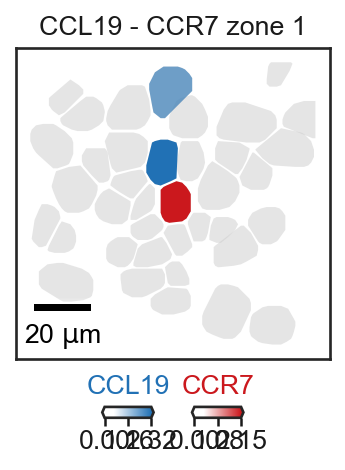

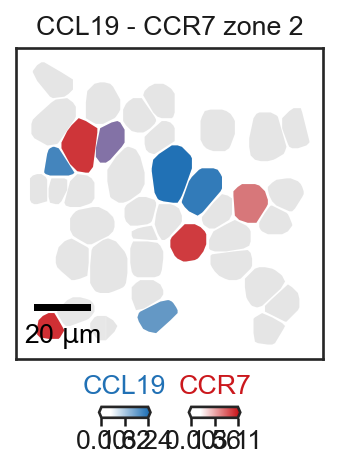

In [10]:
SLE2_adata = ST_adata[ST_adata.obs['sample'] == 'SLE2']  

for i, gene in enumerate(LRs):
    ligand_gene = LRs[i][0]
    receptor_gene = LRs[i][1]
    for j in [0, 1]:
        zone_adata = within(SLE2_adata, zones[i][j], reduction ='contour', inplace=True)

        source_ligand = (zone_adata.obs.subtype.isin(['FB_IFN'])) & (fetch_data(zone_adata, ligand_gene).sum(axis=1) > 0)
        target_receptor = (zone_adata.obs.celltype.isin(['Macrophage/DC','T cells',"B cells"])) & (fetch_data(zone_adata, receptor_gene).sum(axis=1) > 0)      
          
        ax = plot_spatial(zone_adata[source_ligand | target_receptor], 
                          [ligand_gene,receptor_gene], 
                          reduction='contour', show_img=False, max_color_quantile=.95, figsize=[3,3], raster=False, 
                          style='fast', reorder_cmap=[2,1])
        
        dimplot(zone_adata, reduction='contour', ax=ax, raster=False)
        draw_scalebar(ax=ax, location='lower left', color='black')
        ax.set_title(f"{ligand_gene} - {receptor_gene} zone {j+1 }")
        sns.despine(ax=ax, right=False, top=False, left=False, bottom=False)

In [15]:
celltype_color = {
    "VEC_CCL14+":"#003a7d",
    "Fibroblasts" : "#8FB0FF",
    "T cells" : "#63FFAC",   
    "NK cells" : "#9467BD" ,
    "B cells" : "#FF34FF",
    "Plasma cells" :"#FF7F0EFF",
    "Macrophage/DC" : "#008941",
    'FB_IFN' : '#008dff'
    
}

[13:57:06] 📃  Filtering contour within bounding box [16500, 16400, 17500, 17600]            ]8;id=170110;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=657009;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=24886;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=913944;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=209332;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=458211;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

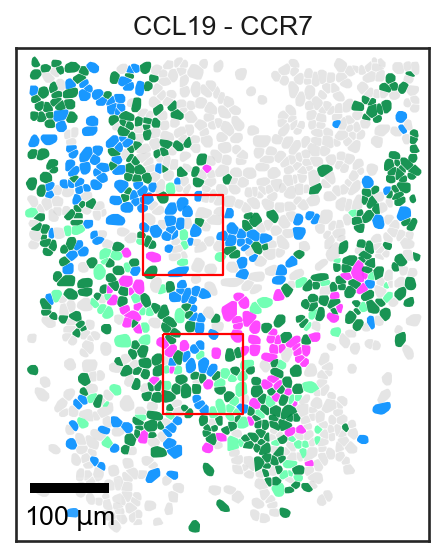

In [21]:
SLE2_adata = ST_adata[ST_adata.obs['sample'] == 'SLE2']  


zone = [[16500,16400,17500,17600]]
for i, gene in enumerate(LRs):
    ligand_gene = LRs[i][0]
    receptor_gene = LRs[i][1]
    zone_adata = within(SLE2_adata, zone[i], reduction ='contour', inplace=True)
    zone_adata.obs['celltype'] = zone_adata.obs.apply(lambda x: x['subtype'] if 'Fibroblasts' in x['celltype'] else x['celltype'], axis=1)
    celltype = ['FB_IFN', 'T cells','B cells', 'Macrophage/DC']
        
    ax= dimplot(zone_adata, background=True, reduction='contour', groupby='celltype', order = celltype, palette=celltype_color,legend=False)
    draw_scalebar(ax=ax, location='lower left', color='black')
    ax.set_title(f"{ligand_gene} - {receptor_gene}")
    gpd.GeoSeries(polygons[i]).plot(ax=ax, edgecolor='red',facecolor='none', linewidth=1)
    sns.despine(ax=ax, right=False, top=False, left=False, bottom=False)
    ax.set_xlim([zone[i][0]-20,zone[i][2]+20])
    ax.set_ylim([zone[i][1]-20,zone[i][3]+20])

[13:55:57] 📃  Filtering contour within bounding box [16800, 17050, 17000, 17250]            ]8;id=488797;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=394054;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=500727;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=108184;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=98349;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=68375;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

[13:55:58] 📃  Filtering contour within bounding box [16850, 16700, 17050, 16900]            ]8;id=177905;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=902689;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=52142;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=259551;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=787571;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=710334;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

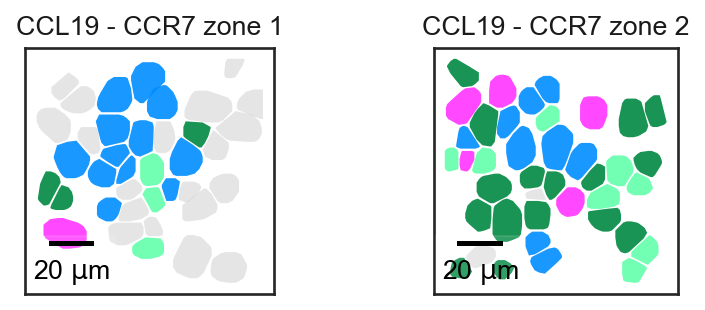

In [18]:
SLE2_adata = ST_adata[ST_adata.obs['sample'] == 'SLE2']  

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6, 2),squeeze=False)

for i, gene in enumerate(LRs):
    ligand_gene = LRs[i][0]
    receptor_gene = LRs[i][1]
    for j in [0, 1]:
        ax = axs[i,j]
        zone_adata = within(SLE2_adata, zones[i][j], reduction ='contour', inplace=True) 
        zone_adata.obs['celltype'] = zone_adata.obs.apply(lambda x: x['subtype'] if 'Fibroblasts' in x['celltype'] else x['celltype'], axis=1)
        celltype = ['FB_IFN', 'T cells','B cells', 'Macrophage/DC']
        
        ax= dimplot(zone_adata, background=True, reduction='contour', groupby='celltype', order = celltype, palette=celltype_color, ax=ax, legend=False)
        draw_scalebar(ax=ax, location='lower left', color='black')
        ax.set_title(f"{ligand_gene} - {receptor_gene} zone {j+1}")
        sns.despine(ax=ax, right=False, top=False, left=False, bottom=False)